[View in Colaboratory](https://colab.research.google.com/github/PranY/FastAI_projects/blob/master/TSG.ipynb)

In [0]:
!pip install fastai

In [3]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 575.3MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61812000 @  0x7effee5a12a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
! pip install kaggle


In [5]:
! pip install tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! ls "drive/My Drive"

In [0]:
! cp drive/My\ Drive/kaggle.json ~/.kaggle/

In [0]:
! kaggle competitions download -c tgs-salt-identification-challenge

In [13]:
! python -c 'import fastai; print(fastai.__version__)'
! python -c 'import fastai; fastai.show_install(0)'

1.0.5

```
platform info  : Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
distro version : #1 SMP Sun Sep 9 02:18:33 PDT 2018
python version : 3.6.6
fastai version : 1.0.5
torch version  : 1.0.0.dev20181014
nvidia driver  : 396.44
cuda version   : 9.2.148
cudnn version  : 7104
cudnn available: True
torch gpu count: 1
  [gpu0]
  name         : Tesla K80
  total memory : 11441MB
```

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run this utility to get the additional information


In [14]:
!ls

depths.csv  sample_data		   test.zip   train.zip
drive	    sample_submission.csv  train.csv


In [0]:
# ! rm -r train/
# !rm -r test/

In [0]:
! mkdir train
! mkdir test

In [0]:
! unzip train.zip -d train

In [0]:
! unzip test.zip -d test

In [1]:
! ls train/images | wc -l
! ls train/masks | wc -l
! ls test/images | wc -l

4000
4000
18000


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from tqdm import tqdm_notebook

In [0]:
from fastai import *
from fastai.vision import *
from fastai.docs import *

In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]
num_workers=0
len(train_df)


4000

In [0]:
PATH_X = Path('train/images')
PATH_Y = Path('train/masks')

In [0]:
# def resize2d(fn:PathOrStr, sz) -> Image:
#     img = PIL.Image.open(fn)
#     img = img.resize((sz,sz), PIL.Image.BILINEAR)
#     img.save(fn)

In [0]:
# for l in list(PATH_X.iterdir()):
#   resize2d(l,128)

In [0]:
# for l in list(PATH_Y.iterdir()):
#   resize2d(l,128)

In [0]:
# Reducing mask images to {0,1}

def FormatMask(fn:PathOrStr) -> Image:

    img = PIL.Image.open(fn).convert('L')

    # Let numpy do the heavy lifting for converting pixels to pure black or white
    bw = np.asarray(img).copy()

    # Pixel range is 0...255, 256/2 = 128
    bw[bw < 128] = 0    # Black
    bw[bw >= 128] = 1 # White

    # Now we put it back in Pillow/PIL land
    imfile = PIL.Image.fromarray(bw)
    imfile.save(fn)

In [0]:
for l in list(PATH_Y.iterdir()):
  FormatMask(l)

In [0]:
class ImageMask(Image):
    "Class for image segmentation target."
    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any)->'Image': return self

    def refresh(self):
        self.sample_kwargs['mode'] = 'bilinear'
        return super().refresh()

    @property
    def data(self)->TensorImage:
        "Return this image pixels as a `LongTensor`."
        return self.px.long()
    
    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True, 
        cmap:str='viridis', alpha:float=0.5):
        ax = _show_image(self, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize, alpha=alpha)
        if title: ax.set_title(title)
        
def open_mask(fn:PathOrStr)->ImageMask:
    "Return `ImageMask` object create from mask in file `fn`."
    x = PIL.Image.open(fn).convert('L')
    return ImageMask(pil2tensor(x).float().div_(255))
  
def _show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
                alpha:float=None)->plt.Axes:
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha)
    if hide_axis: ax.axis('off')
    return ax

torch.Size([101, 101])

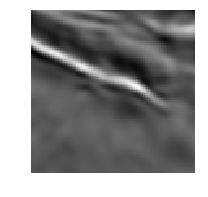

In [12]:
img = next(PATH_X.iterdir())
open_image(img).show()
open_image(img).size

torch.Size([101, 101])

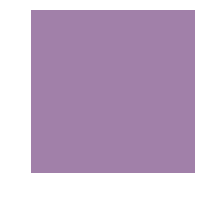

In [14]:
def get_y_fn(x_fn): return PATH_Y/f'{x_fn.name[:-4]}.png'

img_y_f = get_y_fn(img)
open_mask(img_y_f).show()
open_mask(img_y_f).size

torch.Size([3, 101, 101])

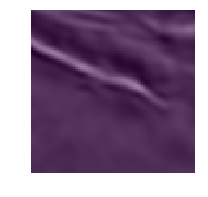

In [15]:
x = open_image(img)
x.show(y=open_mask(img_y_f))
x.shape

In [16]:
open_image(img).shape, open_mask(img_y_f).shape

(torch.Size([3, 101, 101]), torch.Size([1, 101, 101]))

In [0]:
def get_datasets(path):
    x_fns = [o for o in path.iterdir() if o.is_file()]
    y_fns = [get_y_fn(o) for o in x_fns]
    mask = [o>=1000 for o in range(len(x_fns))]
    arrs = arrays_split(mask, x_fns, y_fns)
    return [SegmentationDataset(*o) for o in arrs]


In [19]:
train_ds,valid_ds = get_datasets(PATH_X)
train_ds,valid_ds

(SegmentationDataset of len 3000, SegmentationDataset of len 1000)

In [20]:
x,y = next(iter(train_ds))
x.shape, y.shape, type(x), type(y)

(torch.Size([3, 101, 101]),
 torch.Size([1, 101, 101]),
 fastai.vision.image.Image,
 fastai.vision.image.ImageMask)

In [0]:
size = 128

In [0]:
def get_tfm_datasets(size):
    datasets = get_datasets(PATH_X)
    tfms = get_transforms(do_flip=True, max_rotate=4, max_lighting=0.2)
    return transform_datasets(train_ds, valid_ds, tfms=tfms, tfm_y=True, size=size, padding_mode='border')

In [0]:
train_tds, *_ = get_tfm_datasets(size)

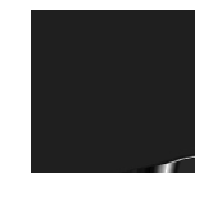

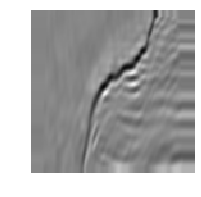

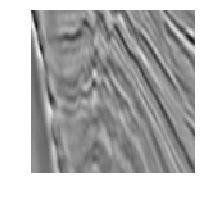

In [24]:
for i in range(0,3):
  train_tds[i][0].show()

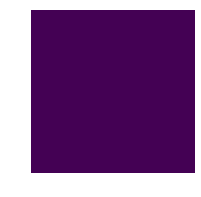

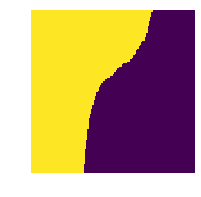

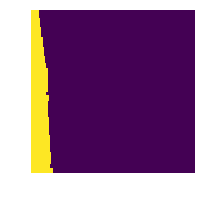

In [25]:
for i in range(0,3):
  train_tds[i][1].show()

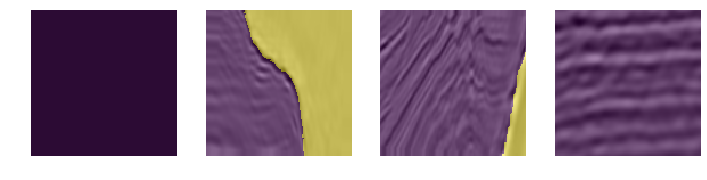

In [26]:
_,axes = plt.subplots(1,4, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    imgx,imgy = train_tds[i]
    imgx.show(ax, y=imgy)

In [0]:
default_norm,default_denorm = normalize_funcs( mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
bs = 32

In [0]:
def get_data(size, bs):
    return DataBunch.create(*get_tfm_datasets(size), bs=bs, tfms=default_norm)

In [0]:
data = get_data(size, bs)

In [0]:
#export
def show_xy_images(x:Tensor,y:Tensor,rows:int,figsize:tuple=(9,9)):
    "Shows a selection of images and targets from a given batch."
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()): show_image(x[i], y=y[i], ax=ax)
    plt.tight_layout()

(torch.Size([32, 3, 128, 128]), torch.Size([32, 1, 128, 128]))

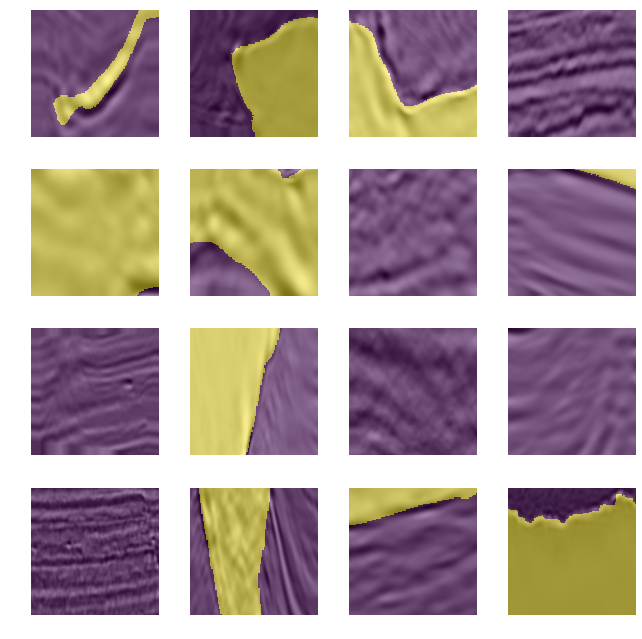

In [31]:
x,y = next(iter(data.train_dl))
x,y = x.cpu(),y.cpu()
x = default_denorm(x)
show_xy_images(x,y,4, figsize=(9,9))
x.shape, y.shape

In [32]:
head = std_upsample_head(2, 512,256,256,256,256)
head

Sequential(
  (0): ReLU()
  (1): StdUpsample(
    (conv): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): ConvTranspose2d(256, 2, kernel_size=(2, 2), stride=(2, 2))
)

In [0]:
def dice(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "Dice coefficient metric for binary target"
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return 2. * intersect / union

def accuracy(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "Accuracy"
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [0]:
metrics=[accuracy, dice]

In [0]:
learn = ConvLearner(data, tvm.resnet34, custom_head=head,
                    metrics=metrics, loss_fn=CrossEntropyFlat())

epoch  train loss  valid loss  accuracy  dice
0      4.490642  


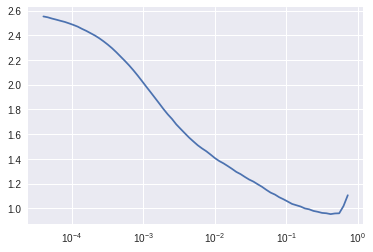

In [36]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-1

In [38]:
learn.fit_one_cycle(10, slice(lr))

epoch  train loss  valid loss  accuracy  dice


RuntimeError: ignored

In [39]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.7 GB  | Proc size: 2.0 GB
GPU RAM Free: 10674MB | Used: 767MB | Util   7% | Total 11441MB
